## Kelley hu4d5-5 VH-Y100aA error analysis

In this notebook we will use a random forest model to find the most energetically influential degrees of freedom for the VH-Y100aA TI production run. Next, we will compare the sampling of these DOF during TI production to a free energy profile derived from end state GaMD sampling. We will attempt to  correct any inaccurate sampling in the TI data and find the estimated ddG before and after the correction. 

In [1]:
import os
os.chdir("..")
from common_functions import *

### Ingesting original runs

In [2]:
os.chdir("./TI_data/VH-Y100aA")
geom_dvdls = pd.read_csv("Y100aA_bound.csv")
dvdls_ub = pd.read_csv("Y100aA_unbound.csv")

### Original ddG estimate:

In [3]:
orig_dG_bd = geom_dvdls.groupby("Lambda").mean().sum()["weight_dvdl"]
orig_dG_ubd = dvdls_ub.groupby("Lambda").mean().sum()["weight_dvdl"]

empirical_value = 4.23
orig_error = abs((orig_dG_bd - orig_dG_ubd) - empirical_value)

print("Original ddG estimate: ")
print(f"{round(orig_dG_bd - orig_dG_ubd, 4)} kcal/mol ")
print()
print("Original ddG error: ")
print(f"{round(orig_error, 4)} kcal/mol")

Original ddG estimate: 
4.5502 kcal/mol 

Original ddG error: 
0.3202 kcal/mol


### Splitting data into independent/dependent variables for random forest model

See our methods/supplemental methods section for our process to choose the input features. We are also removing correlated variables among candidate degrees of freedom - this is important because we want to limit the noise in our model training. 

In [4]:
X = geom_dvdls.drop([
    "#Frame", "weight_dvdl", "dvdl", "Run", "Lambda", "Y454_K106", "Y184_chi2", "Y382_chi2"
], axis=1)

Y = geom_dvdls["weight_dvdl"]

X_scl = pd.DataFrame(StandardScaler().fit_transform(X))
X_scl.columns = X.columns


### Checking to see if there is any cross-correlations within the independent variables

In [5]:
absCorr = abs(X_scl.corr())
for i in absCorr.columns:
    for j in absCorr.index:
        cor = absCorr.loc[i, j]
        if abs(cor) > 0.5 and i != j:
            print(i, j)
            print(cor)
            

### Using random forest model to identify the most energetically influential degrees of freedom

We run our model 25 times, then sort the results by the mean of feature importance across the 25 iterations. Here, the random forest model found Ag-K106 side chain rotamer chi3 to be the most influential features on the DV/DL during TI lambda production.

In [15]:
rfeDefault = RFE(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_features_to_select=0.75, step=0.05)
rfDefault = RandomForestRegressor(
    max_depth=10, n_estimators=200, oob_score=True, max_features=0.6, min_samples_leaf = 7, min_samples_split=14, random_state=42
)

pipelineDefault_rf = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('feature_selection', rfeDefault),
    ('regression_model', rfDefault)
])


imps = benchmark_model(pipelineDefault_rf, X_scl, Y, geom_dvdls["Lambda"])
imps[["Mean", "Median"]].sort_values(by="Mean", ascending=False)[:15]

Avg. training r2: 
0.6974
Training r2 std dev: 
0.0004
Avg. test r2: 
0.5907
Testing r2 std dev: 
0.0061


,Mean,Median
K106_chi3,0.164274,0.183728
Y454_D83,0.141179,0.141081
Y454_chi2,0.096108,0.103235
Y454_chi1,0.094010,0.102122
M456_chi1,0.064314,0.061858
F453_chi2,0.060683,0.071827
D451_chi2,0.056157,0.071238
F86_chi2,0.052807,0.041160
Q224_chi3,0.040887,0.045774
W448_chi2,0.040136,0.032174


### Comparing the TI rotamer sampling with the GaMD pmf (bound state)

The RF model tells us that the most energetically influential features to DV/DL is "K106_chi3" aka Ag-K106 side chain rotamer chi3. We used GaMD on the WT hu4d5-5 complex to obtain enhanced sampling data for this end state. Then, we used PyReweighting-1D to generate a 1-D PMF of Ag-K106 chi3 to give us an idea of the ideal sampling of this energetically influential feature. Finally, we plot the Ag-K106 rotamer explored during TI overlaid onto the GaMD pmf to probe the quality of sampling during TI.

As we can see, there are a few frames during TI in which the system explores states found unfavorable by GaMD. 

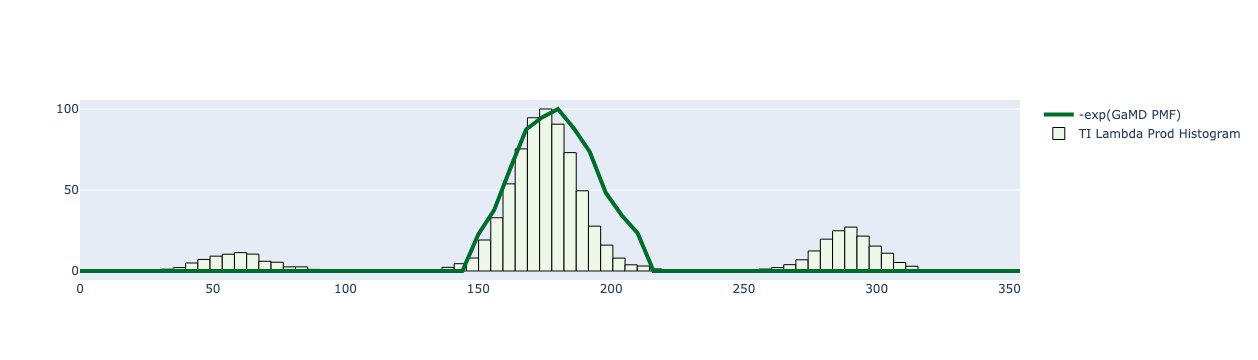

In [6]:
os.chdir("../../gamd_pmfs/VH-Y100aA")
k106_c3 = get_pmf(
    "pmf-c2-chi3_conv.dat.xvg"
)

geom_dvdls.loc[geom_dvdls["K106_chi3"] < 0, "K106_chi3"] += 360
k106_c3.loc[k106_c3["X"] < 0, "X"] += 360
k106_c3 = k106_c3.sort_values(by="X")

pio.renderers.default="jupyterlab"
fig = plot_pmf_TI_1D_fig(k106_c3, geom_dvdls, "K106_chi3", scaler=100, bins=75)
fig.show(renderer="jupyterlab")



### Filtering out frames that are not contained within the GaMD free energy profile

In [16]:
state = geom_dvdls[(geom_dvdls["K106_chi3"] > 126) & (geom_dvdls["K106_chi3"] < 228)]
print(state.groupby("Lambda").count()['weight_dvdl'])
dG_corr = state.groupby("Lambda").mean().sum()['weight_dvdl']

Lambda
1     836
2     715
3     637
4     773
5     868
6     747
7     697
8     505
9     729
10    749
11    822
12    802
Name: weight_dvdl, dtype: int64


### Re-computing bound state dG with only the frames that conform to GaMD 1-D free energy profile

We cannot do the same for the unbound state since this feature is only a bound state feature (there is no antigen being sampled in the unbound state). As we can see, this correction has a minimal impact on the error of the prediction.

In [21]:
print("Original ddG estimate: ")
print(f"{round(orig_dG_bd - orig_dG_ubd, 4)} kcal/mol ")
print("Original ddG error: ")
print(f"{round(orig_error, 4)} kcal/mol")

print()
corr_error = abs((dG_corr - orig_dG_ubd) - empirical_value)


print("Corrected ddG estimate: ")
print(f"{round(dG_corr - orig_dG_ubd, 4)} kcal/mol ")
print("Corrected ddG error: ")
print(f"{round(corr_error, 4)} kcal/mol")



Original ddG estimate: 
4.5502 kcal/mol 
Original ddG error: 
0.3202 kcal/mol

Corrected ddG estimate: 
3.8389 kcal/mol 
Corrected ddG error: 
0.3911 kcal/mol
